# 1. Import Dependencies and Data

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip list

Package                      Version
---------------------------- -----------------------
absl-py                      1.4.0
accelerate                   0.34.2
altair                       4.2.2
annotated-types              0.7.0
anyio                        3.7.1
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
array_record                 0.5.1
astunparse                   1.6.3
attrs                        24.2.0
audioread                    3.0.1
backcall                     0.2.0
beautifulsoup4               4.12.3
bleach                       6.1.0
blinker                      1.4
blis                         0.7.11
cachetools                   5.5.0
catalogue                    2.0.10
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.4.0
chex                         0.1.87
click                        8.1.7
cloudpathlib                 0.20.0
cloudpickle                  3.1.0
confection             

In [3]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Brining in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [5]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.6M2XEW_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.6M2XEW_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [7]:
# Do some data transformation
import numpy as np

In [8]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [9]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

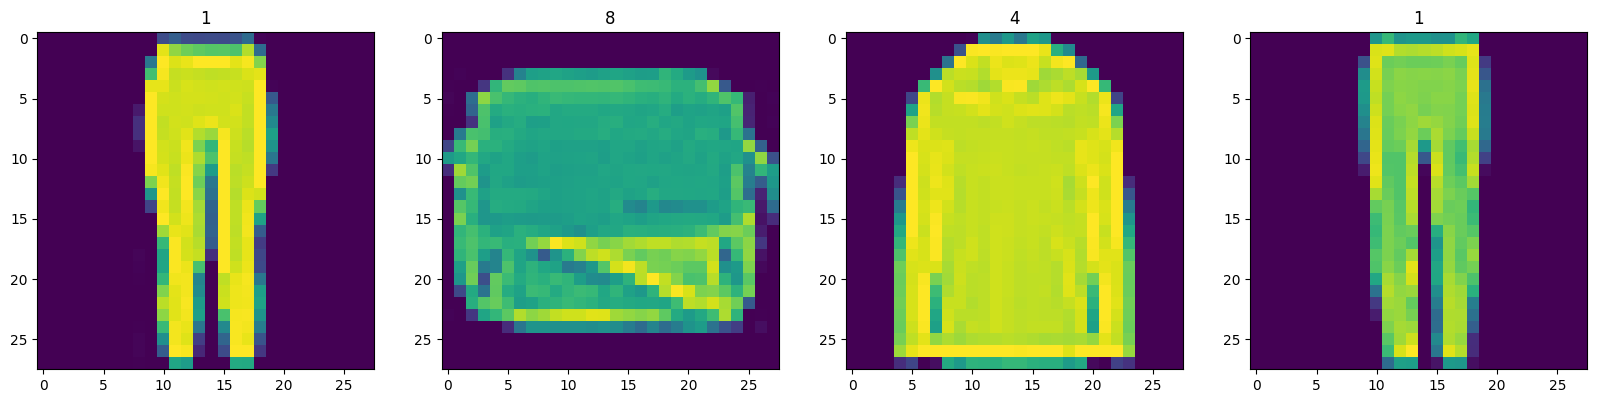

In [10]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title
    ax[idx].title.set_text(sample['label'])

In [11]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [12]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [13]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [14]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [15]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [16]:
generator = build_generator()

In [17]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [18]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 35ms/step


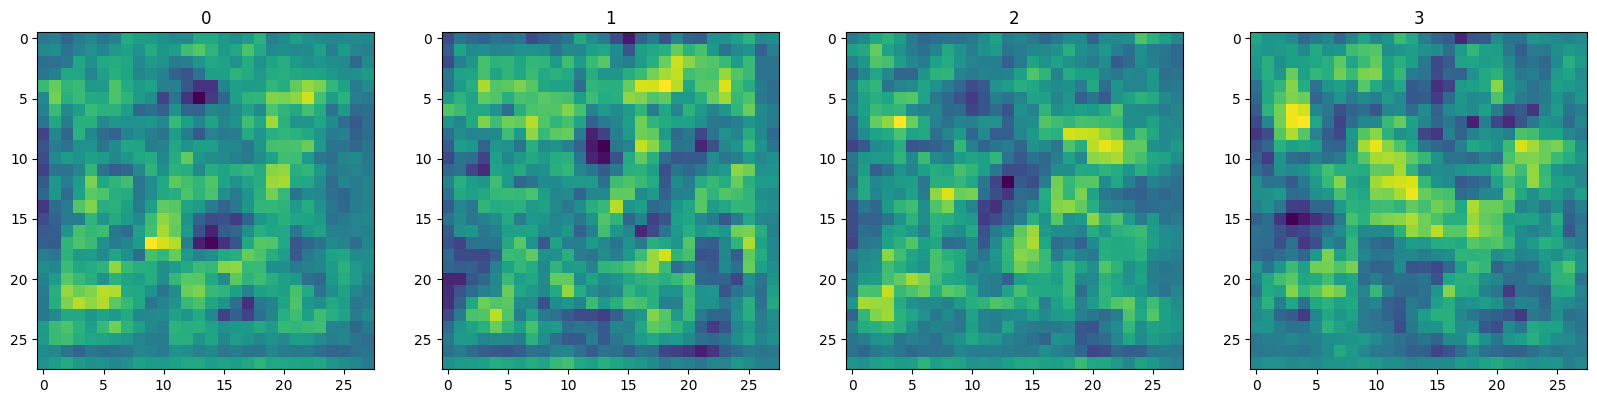

In [19]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [20]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [21]:
discriminator = build_discriminator()

In [22]:
discriminator = build_discriminator()  # Make sure this is done before predicting
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)      

In [33]:
img = img[0]

In [34]:
img.shape

(28, 28, 1)

In [31]:
import numpy as np

# Reshape 'img' to have the correct dimensions
img = img.reshape(1, 28, 28, 1)  # Add a batch dimension and potentially adjust channels

# Now you can predict
predictions = discriminator.predict(img)

ValueError: cannot reshape array of size 3136 into shape (1,28,28,1)

In [29]:
import numpy as np

# Assuming 'img' currently has shape (28, 1)
# Reshape to (28, 28, 1) - assuming a 28x28 grayscale image
img = img.reshape(28, 28, 1)

# Reshape to add a batch dimension with batch_size=1
img = img[np.newaxis, ...] # Reshape to (1, 28, 28, 1)

# Now you can predict
prediction = discriminator.predict(img)

ValueError: cannot reshape array of size 28 into shape (28,28,1)

In [32]:
import numpy as np
from tensorflow import keras


new_img = np.zeros((1, 28, 28, 1))
# Reshape 'img' to (28,) before assigning
new_img[0, :, 0, 0] = img[:, 0, 0]  # Use img[:, 0, 0] to select the data and match shape

predictions = discriminator.predict(new_img)

ValueError: could not broadcast input array from shape (4,1) into shape (28,)

1/1 [==============================] - 0s 76ms/step
Predictions: [[0.49707347]
 [0.49685326]
 [0.49697706]
 [0.49705958]]


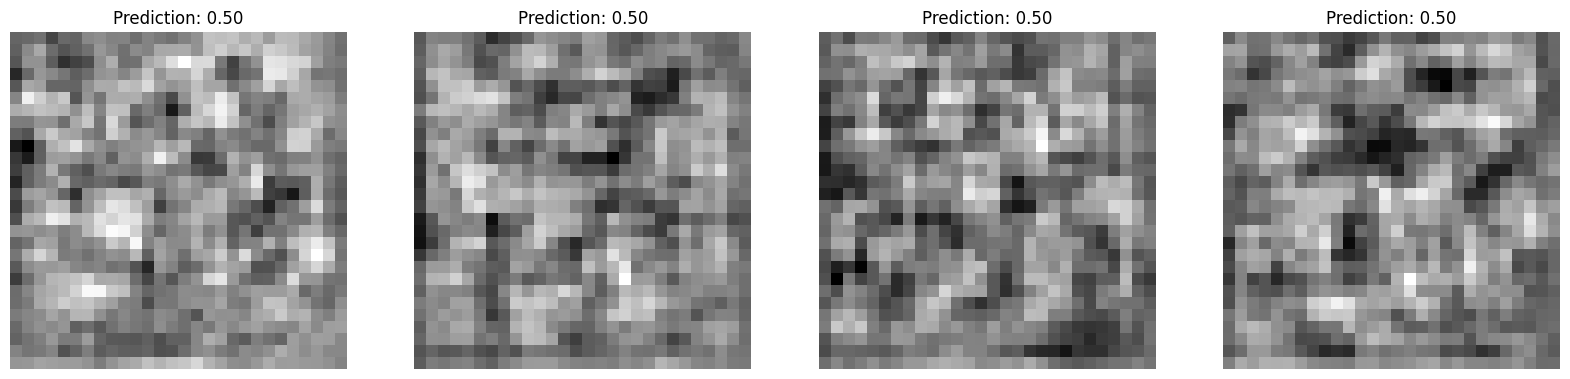

In [30]:
# Generate new fashion images
img = generator.predict(np.random.randn(4, 128, 1))  # Example with 4 random images

# Predict using the discriminator
predictions = discriminator.predict(img)

# Print the predictions
print("Predictions:", predictions)

# Optionally, visualize the generated images with their predictions
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
for idx, image in enumerate(img):
    ax[idx].imshow(np.squeeze(image), cmap='gray')
    ax[idx].title.set_text(f"Prediction: {predictions[idx][0]:.2f}")
    ax[idx].axis('off')
plt.show()


In [ ]:
import numpy as np

# Assuming 'img' currently has shape (28, 1)
# Reshape to (28, 28, 1) - assuming a 28x28 grayscale image
img = img.reshape(28, 28, 1)

# Reshape to add a batch dimension with batch_size=1
img = img[np.newaxis, ...] # Reshape to (1, 28, 28, 1)

# Now you can predict
prediction = discriminator.predict(img)

In [38]:
import numpy as np

# Assuming 'img' has shape (28, 28, 1)

# Add a batch dimension using np.expand_dims
img = np.expand_dims(img, axis=0)  # Now img has shape (1, 28, 28, 1)

# Now you can predict
prediction = discriminator.predict(img)


1/1 [==============================] - 0s 28ms/step


In [40]:
prediction = discriminator.predict(img)
prediction

1/1 [==============================] - 0s 27ms/step


array([[0.49707347]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [41]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [42]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [43]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [44]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [45]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [46]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [47]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [48]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train

In [50]:
if not os.path.exists('images'):
    os.makedirs('images')

In [52]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=7, callbacks=[ModelMonitor()])

Epoch 1/7
469/469 [==============================] - 689s 1s/step - d_loss: 0.6883 - g_loss: 0.7206
Epoch 2/7
469/469 [==============================] - 689s 1s/step - d_loss: 0.3946 - g_loss: 2.2155
Epoch 3/7
469/469 [==============================] - 689s 1s/step - d_loss: 0.6664 - g_loss: 0.8062
Epoch 4/7
469/469 [==============================] - 689s 1s/step - d_loss: 0.6928 - g_loss: 0.6463
Epoch 5/7
469/469 [==============================] - 688s 1s/step - d_loss: 0.6946 - g_loss: 0.6536
Epoch 6/7
469/469 [==============================] - 690s 1s/step - d_loss: 0.6965 - g_loss: 0.6451
Epoch 7/7
469/469 [==============================] - 687s 1s/step - d_loss: 0.6912 - g_loss: 0.6630


### 4.4 Review Performance

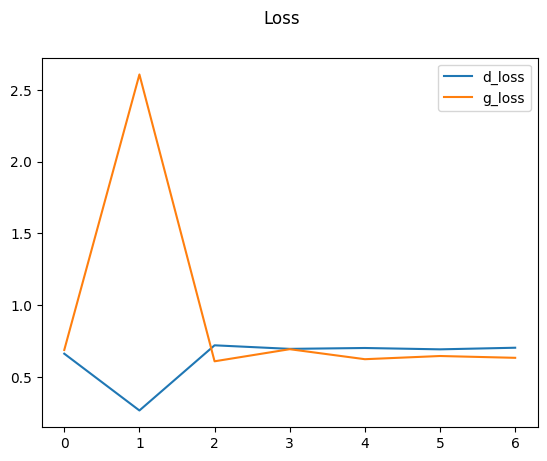

In [53]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [66]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [65]:
import os
print(os.listdir('archive'))


['generatormodel.h5']


In [59]:
# Example code to save generator weights after training
generator.save_weights(os.path.join('archive', 'generatormodel.h5'))


In [60]:
generator.load_weights('path/to/generatormodel.h5')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'path/to/generatormodel.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [56]:
import os
import h5py # to ensure this module is imported

# Check if the 'archive' directory exists. If not, create it.
if not os.path.exists('archive'):
    os.makedirs('archive')

# Check if the file exists within the 'archive' directory.
file_path = os.path.join('archive', 'generatormodel.h5')
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}. Please ensure the file exists.")
else:
    # Load the weights if the file exists.
    generator.load_weights(file_path)

Error: File not found at archive/generatormodel.h5. Please ensure the file exists.


In [67]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 44ms/step


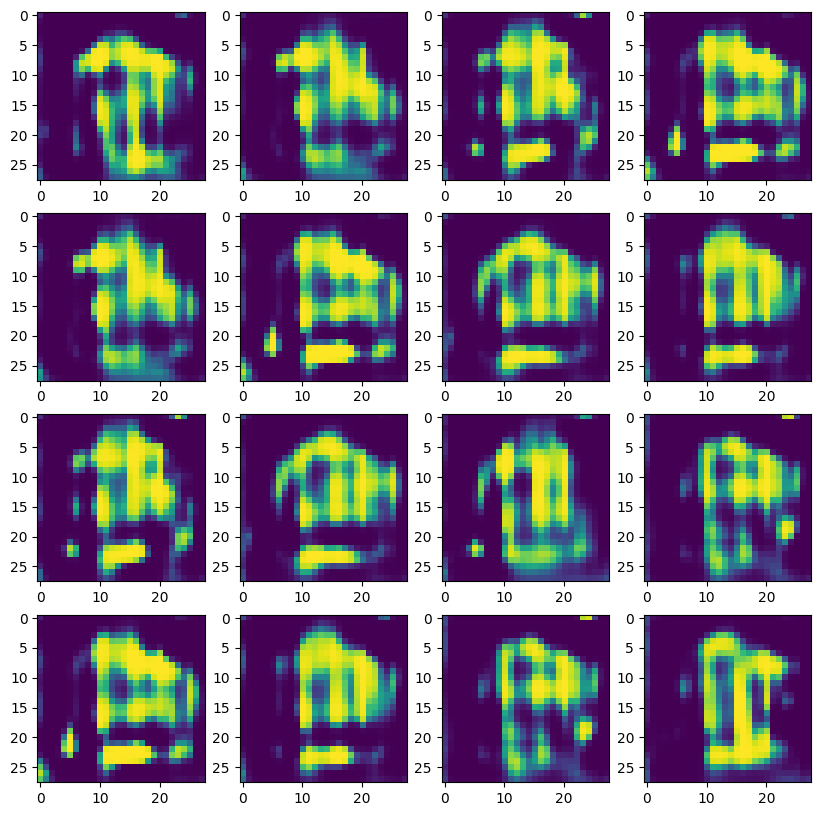

In [68]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [69]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
